In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from datetime import datetime
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import (
    Flask, render_template, jsonify,
    request, redirect)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Database Setup
engine = create_engine("sqlite:///video_games.sqlite")

Base = automap_base()
Base.prepare(engine, reflect=True)

Videogames = Base.classes.videogames
session = Session(engine)

In [3]:
# Read into Pandas
stmt = session.query(Videogames).statement
df = pd.read_sql_query(stmt, session.bind)
df.head()

,ID,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54,76,51,8,324,E
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,,,,,
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.80,3.79,3.29,35.57,82,73,8.3,712,E
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.95,3.28,2.95,32.78,80,73,8,193,E
4,5,Pokemon Red/Pokemon Blue,G,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,,,,,


In [4]:
df.dtypes

ID                   int64
Name                object
Platform            object
Year_of_Release     object
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score        object
Critic_Count        object
User_Score          object
User_Count          object
Rating              object
dtype: object

In [5]:
# Converting columns to numbers
df_nums = df.apply(pd.to_numeric, errors="ignore")
# df_nums.head()

In [6]:
df_nums.dtypes

ID                   int64
Name                object
Platform            object
Year_of_Release     object
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Rating              object
dtype: object

In [7]:
df_nums_drop = df_nums.dropna(axis=0, how="any")
df_nums_drop.head()

,ID,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.54,76.0,51.0,8.0,324.0,E
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.80,3.79,3.29,35.57,82.0,73.0,8.3,712.0,E
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.95,3.28,2.95,32.78,80.0,73.0,8.0,193.0,E
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.28,9.15,6.50,2.88,29.81,89.0,65.0,8.5,433.0,E
7,8,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,E


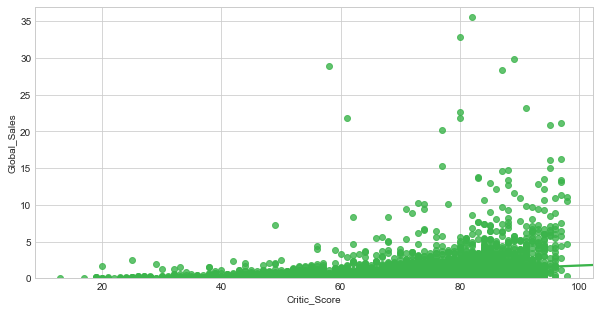

In [8]:
# Visualizing Global Sales vs Critic Score
sns.set_style("whitegrid")
fig = plt.subplots(figsize=(10,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df_nums_drop, color="#3bb44b").set(ylim=(0, 37))
plt.show()

# Prediction

In [9]:
predict_df = df_nums_drop.copy()
predict_df.drop(["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Critic_Count", "User_Score", "User_Count", "Rating"], axis=1, inplace=True)

In [10]:
predict_clean = predict_df.copy()
predict_clean.head()

,ID,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score
0,1,Wii Sports,Wii,2006,Sports,Nintendo,82.54,76.0
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,35.57,82.0
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,32.78,80.0
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,29.81,89.0
7,8,Wii Play,Wii,2006,Misc,Nintendo,28.92,58.0


In [11]:
predict_clean["Hit"] = predict_clean["Global_Sales"]
predict_clean.head(1)

,ID,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Hit
0,1,Wii Sports,Wii,2006,Sports,Nintendo,82.54,76.0,82.54


In [12]:
def recode(series):
    if series >= 1:
        return 1
    else:
        return 0

predict_clean["Hit"] = predict_clean["Hit"].apply(recode)
predict_clean.head(1)

,ID,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Hit
0,1,Wii Sports,Wii,2006,Sports,Nintendo,82.54,76.0,1


# Logistic Regression Test

In [13]:
predict_lg = predict_clean.copy()
predict_lg_test = predict_lg[["Year_of_Release", "Critic_Score", "Hit"]]
predict_lg_test.head(1)

,Year_of_Release,Critic_Score,Hit
0,2006,76.0,1


In [14]:
X = predict_lg_test.drop("Hit", axis=1)
y = predict_lg_test["Hit"]
print(X.shape, y.shape)

(7191, 2) (7191,)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [16]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8255145559058038
Testing Data Score: 0.8203559510567296


In [19]:
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [0 0 0 0 0 0 0 1 0 0]
First 10 Actual labels: [0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


In [20]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True).head(20)

,Actual,Prediction
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,1
8,0,0
9,0,0


# Testing the Prediction Model

In [21]:
not_hits = predict_lg.copy()
not_hits_df = not_hits[["Year_of_Release", "Critic_Score", "Hit"]]
not_hits_df = not_hits_df[not_hits_df["Hit"] == 0]

In [22]:
not_hits_test = not_hits_df
y2 = not_hits_test["Hit"].values
not_hits_test = not_hits_test.drop(["Hit"],axis=1)
X2 = not_hits_test.values

In [23]:
prediction_model = classifier.fit(X_train, y_train).predict_proba(X2)

In [24]:
predict_test_df = predict_df.copy()
predict_test_df = predict_test_df[predict_test_df["Global_Sales"] < 1]

In [25]:
predict_test_df["Hit Prediction"] = prediction_model[:,1]

In [26]:
predict_test_df = predict_test_df[predict_test_df["Year_of_Release"] == 2016]
predict_test_df.sort_values(["Hit Prediction"], ascending=False, inplace=True)
predict_test_df.head()

,ID,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Hit Prediction
8526,8527,Odin Sphere: Leifthrasir,PSV,2016,Role-Playing,Nippon Ichi Software,0.16,93.0,0.531382
3143,3144,Overwatch,PC,2016,Shooter,Activision,0.65,91.0,0.487137
15122,15123,NBA 2K17,PC,2016,Sports,Take-Two Interactive,0.02,90.0,0.465047
11414,11415,Dark Souls III,PC,2016,Role-Playing,Namco Bandai Games,0.08,89.0,0.443093
4265,4266,Dishonored 2,XOne,2016,Action,Bethesda Softworks,0.46,88.0,0.421359


In [27]:
predict_test_df2 = predict_test_df[["Name", "Platform", "Genre", "Publisher", "Hit Prediction"]]
predict_test_df2[:10]

,Name,Platform,Genre,Publisher,Hit Prediction
8526,Odin Sphere: Leifthrasir,PSV,Role-Playing,Nippon Ichi Software,0.531382
3143,Overwatch,PC,Shooter,Activision,0.487137
15122,NBA 2K17,PC,Sports,Take-Two Interactive,0.465047
11414,Dark Souls III,PC,Role-Playing,Namco Bandai Games,0.443093
4265,Dishonored 2,XOne,Action,Bethesda Softworks,0.421359
6552,XCOM 2,PC,Strategy,Take-Two Interactive,0.421359
7701,XCOM 2,PS4,Strategy,Take-Two Interactive,0.421359
3775,Battlefield 1,PC,Shooter,Electronic Arts,0.421359
5576,Sid Meiers Civilization VI,PC,Strategy,Take-Two Interactive,0.421359
5099,World of Warcraft: Legion,PC,Role-Playing,Activision,0.421359


In [28]:
predict_test_df2[:-11:-1]

,Name,Platform,Genre,Publisher,Hit Prediction
15601,Cartoon Network Battle Crashers,PS4,Action,FuRyu Corporation,0.001923
15217,Dino Dinis Kick Off Revival,PS4,Sports,Avanquest,0.004650
11634,7 Days to Die,XOne,Action,Telltale Games,0.006615
15345,RollerCoaster Tycoon World,PC,Simulation,Atari,0.013344
12863,Dead or Alive Xtreme 3: Fortune,PS4,Sports,Tecmo Koei,0.013344
15604,Super Dungeon Bros,PS4,Action,Nordic Games,0.013344
10271,Teenage Mutant Ninja Turtles: Mutants in Manha...,PS4,Action,Activision,0.014562
8496,7 Days to Die,PS4,Action,Telltale Games,0.015890
14643,Bus Simulator 16,PC,Simulation,Astragon,0.017336
13812,Mighty No. 9,WiiU,Platform,Deep Silver,0.020627
